In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
path = '/content/drive/MyDrive/chbmit_preprocessed_data.csv'
df = pd.read_csv(path)


In [ ]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())


Shape: (2097150, 24)
Columns: ['# FP1-F7', 'C3-P3', 'C4-P4', 'CZ-PZ', 'F3-C3', 'F4-C4', 'F7-T7', 'F8-T8', 'FP1-F3', 'FP2-F4', 'FP2-F8', 'FT10-T8', 'FT9-FT10', 'FZ-CZ', 'P3-O1', 'P4-O2', 'P7-O1', 'P7-T7', 'P8-O2', 'T7-FT9', 'T7-P7', 'T8-P8-0', 'T8-P8-1', 'Outcome']


In [ ]:
print("Class Distribution:")
print(df['Outcome'].value_counts())


Class Distribution:
Outcome
0.0    1048575
1.0    1048575
Name: count, dtype: int64


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Spectral GCN Layer
class SGCNLayer(nn.Module):
    def __init__(self, in_features, out_features, adj):
        super(SGCNLayer, self).__init__()
        self.adj = adj
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
      batch, time_steps, num_features = x.size()
      x = x.view(-1, num_features)  # (batch*time, features)

      # Move adjacency matrix to same device as input
      adj = self.adj.to(x.device)

      x = torch.matmul(adj, x.T).T  # spectral filtering
      x = self.linear(x)
      return x.view(batch, time_steps, -1)


In [ ]:
# Deep RNN (3 LSTM layers)
class DeepRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(DeepRNN, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])  # only final time step output


In [ ]:
# Combined Model
class SGCN_RNN_Model(nn.Module):
    def __init__(self, in_features, adj, gcn_out=32, rnn_hidden=64, num_layers=3):
        super(SGCN_RNN_Model, self).__init__()
        self.sgcn = SGCNLayer(in_features, gcn_out, adj)
        self.rnn = DeepRNN(gcn_out, rnn_hidden, num_layers, 2)

    def forward(self, x):
        x = self.sgcn(x)
        return self.rnn(x)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Identity adjacency for SGCN (can replace with correlation-based matrix later)
def create_adj_matrix(features=23):
    A = np.identity(features)
    return torch.tensor(A, dtype=torch.float32)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch

# Drop Outcome column for features, keep Outcome for labels
X = df.drop(columns=['Outcome']).values
y = df['Outcome'].values

# Reshape into (samples, time_steps, features)
time_steps = 10
X = X[:len(X) - (len(X) % time_steps)]
y = y[:len(y) - (len(y) % time_steps)]

X = X.reshape(-1, time_steps, 23)
y = y[::time_steps]  # one label per window

# Normalize
X = (X - np.mean(X)) / np.std(X)

# Stratified split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

# Convert to PyTorch tensors
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_ds   = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_ds  = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)


In [ ]:
device = torch.device("cuda")

adj = create_adj_matrix()
model = SGCN_RNN_Model(in_features=23, adj=adj).to(device)


In [ ]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_acc = 0.0

for epoch in range(1, 31):  # 30 epochs
    # === Training ===
    model.train()
    total_train_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # === Validation ===
    model.eval()
    val_preds, val_labels = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            outputs = model(xb)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(yb.numpy())

    val_acc = accuracy_score(val_labels, val_preds)

    print(f"[Epoch {epoch}] Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_sgcn_rnn.pt")
        print(f"✅ Saved new best model (val acc: {val_acc:.4f})")


[Epoch 1] Train Loss: 0.3939 | Val Accuracy: 0.8378
✅ Saved new best model (val acc: 0.8378)
[Epoch 2] Train Loss: 0.3394 | Val Accuracy: 0.8549
✅ Saved new best model (val acc: 0.8549)
[Epoch 3] Train Loss: 0.3166 | Val Accuracy: 0.8605
✅ Saved new best model (val acc: 0.8605)
[Epoch 4] Train Loss: 0.3011 | Val Accuracy: 0.8657
✅ Saved new best model (val acc: 0.8657)
[Epoch 5] Train Loss: 0.2879 | Val Accuracy: 0.8667
✅ Saved new best model (val acc: 0.8667)
[Epoch 6] Train Loss: 0.2761 | Val Accuracy: 0.8738
✅ Saved new best model (val acc: 0.8738)
[Epoch 7] Train Loss: 0.2655 | Val Accuracy: 0.8747
✅ Saved new best model (val acc: 0.8747)
[Epoch 8] Train Loss: 0.2550 | Val Accuracy: 0.8780
✅ Saved new best model (val acc: 0.8780)
[Epoch 9] Train Loss: 0.2457 | Val Accuracy: 0.8763
[Epoch 10] Train Loss: 0.2362 | Val Accuracy: 0.8757
[Epoch 11] Train Loss: 0.2262 | Val Accuracy: 0.8760
[Epoch 12] Train Loss: 0.2174 | Val Accuracy: 0.8793
✅ Saved new best model (val acc: 0.8793)
[Epo

✅ Test Accuracy: 0.8761

📄 Classification Report:
              precision    recall  f1-score   support

 Non-Seizure       0.86      0.90      0.88     15729
     Seizure       0.89      0.85      0.87     15729

    accuracy                           0.88     31458
   macro avg       0.88      0.88      0.88     31458
weighted avg       0.88      0.88      0.88     31458



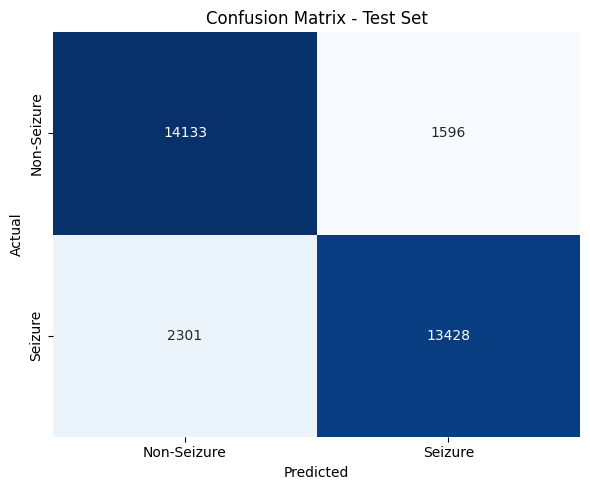

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load("best_sgcn_rnn.pt"))
model.eval()

# Run inference on test set
test_preds, test_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_labels.extend(yb.numpy())

# Accuracy
test_acc = accuracy_score(test_labels, test_preds)
print(f"✅ Test Accuracy: {test_acc:.4f}")

# Classification Report (includes precision, recall, F1-score)
print("\n📄 Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Non-Seizure", "Seizure"]))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Seizure", "Seizure"],
            yticklabels=["Non-Seizure", "Seizure"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()
